# <span style="color:deepskyblue">1.추천 시스템의 개요와 배경 </span>    
---

## <span style="color:lightpink">추천 시스템의 유형</span> 

콘테츠 기반 필터링  
협업 필터링- 최근접 이웃 협업 필터링, 잠재 요인 협업 필터링

# <span style="color:deepskyblue">2.콘테츠 기반 필터링 추천 시스템 </span>    
---

사용자가 특정한 아이템을 매우 선호하는 경우 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템을 추천

# <span style="color:deepskyblue">3.최근접 이웃 협업 필터링 </span>    
---

사용자가 아이템에 매긴 평점 정보나 상품 구매 이력과 같은 사용자 행동 양식만을 기반으로 추천을 수행

축적된 사용자 행동 데이터를 기반으로 사용자가 아직 평가하지 않은 아이템을 예측 평가하는 것이 목표

- 행렬데이터 사용  
행: 개별 사용자  
열: 개별 아이템

사용자-아이템 평점 행렬은 많은 아이템을 가지는 다차원 행렬이지만 평점을 매기는 경우가 많지 않기 때문에 sparse 행렬 특성을 가지고 있음

- 최근접 이웃 협업 필터링  
사용자 기반 : 나랑 비슷한 고객들이 구매한 상품  
아이템 기반 : 이 상품을 선택한 다른 고객이 구매한 다른 상품

사용자 기반은 유사도가 높은 TOP-N을 추출해서 아이템을 추천

아이템 기반은 평가 척도가 유사한 아이템을 추천

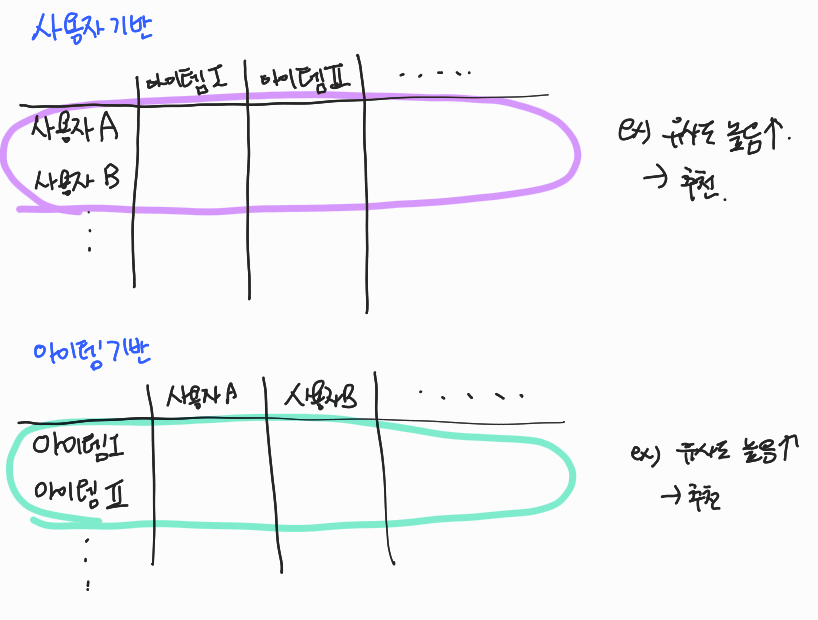

# <span style="color:deepskyblue">4.잠재 요인 협업 필터링 </span>    
---

## <span style="color:lightpink">잠재 요인 협업 필터링 이해</span> 

사용자-아이템 평점 행렬속에 숨어 있는 잠재 요인을 추출해 추천 예측을 할 수 있게 하는 기법  
다차원 행렬은 행렬분해를 통해 잠재 요인을 얻음

## <span style="color:lightpink">행렬 분해의 이해</span> 

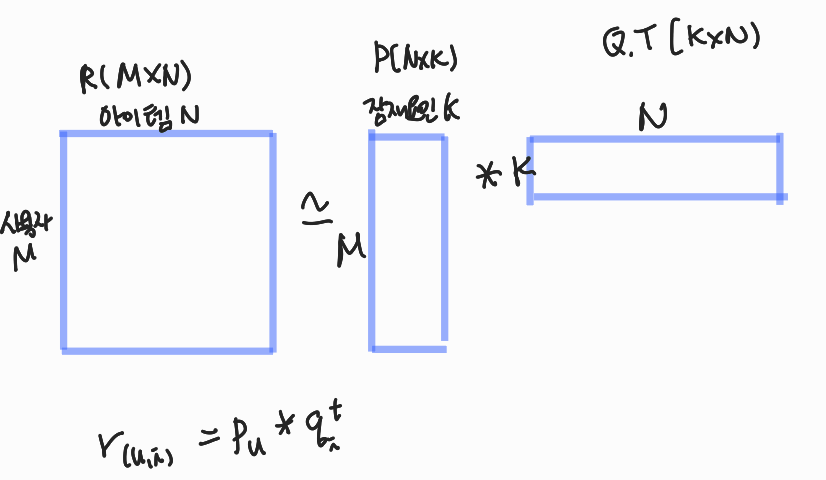

주로 SVD 방식을 이용하지만 NULL값이 존재해서 사용할 수 없음  
-->확률적 경사 하강법이나 ALS를 이용해서 SVD를 적용함

## <span style="color:lightpink">확률적 경사 하강법을 이용한 행렬 분해</span> 

P와 Q로 계산된 $\hat R$이 실제 R과 가장 최소의 오류를 자길 수 있도록 반복적 비용 함수 최적화를 통해 P와 Q를 유추 

- 비용함수  
$min\sum(r_{(u,i)}-p_uq_{i}^{t})^2+\lambda(||{q_u}||^2+||q_i||^2)$

- 새로 업데이트 된 값  
$p_u'=p_u +\eta(e_{(u,i)}*q_i)-\lambda*p_u$  
$q_i'=q_i +\eta(e_{(u,i)}*p_u)-\lambda*q_i$  
$e_{(u,i)}=r_{(u,i)}-\hat r_{(u,i)}$
$\eta$:SGD학습률  
$\lambda$:L-2규제계수

In [1]:
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재요인 차원 K는 3 설정. 
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN ],
              [np.NaN, 5, np.NaN, 3, 1 ],
              [np.NaN, np.NaN, 3, 4, 4 ],
              [5, 2, 1, 2, np.NaN ]])
num_users, num_items = R.shape
K=3

# P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 random한 값으로 입력합니다. 
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

In [4]:
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [5]:
# R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장. 
non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

steps=1000
learning_rate=0.01
r_lambda=0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트. 
for step in range(steps):
    for i, j, r in non_zeros:
        # 실제 값과 예측 값의 차이인 오류 값 구함
        eij = r - np.dot(P[i, :], Q[j, :].T)
        # Regularization을 반영한 SGD 업데이트 공식 적용
        P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
        Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

    rmse = get_rmse(R, P, Q, non_zeros)
    if (step % 50) == 0 :
        print("### iteration step : ", step," rmse : ", rmse)

### iteration step :  0  rmse :  3.2388050277987723
### iteration step :  50  rmse :  0.4876723101369648
### iteration step :  100  rmse :  0.1564340384819247
### iteration step :  150  rmse :  0.07455141311978046
### iteration step :  200  rmse :  0.04325226798579314
### iteration step :  250  rmse :  0.029248328780878973
### iteration step :  300  rmse :  0.022621116143829466
### iteration step :  350  rmse :  0.019493636196525135
### iteration step :  400  rmse :  0.018022719092132704
### iteration step :  450  rmse :  0.01731968595344266
### iteration step :  500  rmse :  0.016973657887570753
### iteration step :  550  rmse :  0.016796804595895633
### iteration step :  600  rmse :  0.01670132290188466
### iteration step :  650  rmse :  0.01664473691247669
### iteration step :  700  rmse :  0.016605910068210026
### iteration step :  750  rmse :  0.016574200475705
### iteration step :  800  rmse :  0.01654431582921597
### iteration step :  850  rmse :  0.01651375177473524
### iterati

In [6]:
pred_matrix = np.dot(P, Q.T)
print('예측 행렬:\n', np.round(pred_matrix, 3))

예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]


In [7]:
R

array([[ 4., nan, nan,  2., nan],
       [nan,  5., nan,  3.,  1.],
       [nan, nan,  3.,  4.,  4.],
       [ 5.,  2.,  1.,  2., nan]])

Null이 아닌 값들은 큰 차이가 나지 않으며 Null은 새로운 값이 채워져 있음